# Deep Learning Sentiment Analysis Submission

This notebook implements 3 deep learning experiments to optimize sentiment analysis on Marketplace reviews. The goal is to achieve >85% accuracy on all experiments (or at least the optimized ones).

In [1]:
import pandas as pd
import numpy as np
import joblib
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline


In [2]:
# --- Config ---
DATA_FILE = 'scraped_reviews.csv'

# --- Cleaning ---
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text) # Remove URLs
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # Remove mentions
    # Keep numbers: [^a-zA-Z0-9\s]
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) 
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'(.)\1{2,}', r'\1', text) # Normalize recurring chars
    return text

def load_data():
    print("Loading data...")
    try:
        df = pd.read_csv(DATA_FILE)
    except FileNotFoundError:
        print(f"Error: {DATA_FILE} not found.")
        return None, None, None

    df['content'] = df['content'].fillna('').astype(str)
    # Apply Cleaning
    print("Applying text cleaning...")
    df['content_clean'] = df['content'].apply(clean_text)
    
    le = LabelEncoder()
    df['label_encoded'] = le.fit_transform(df['label'])
    
    return df['content_clean'], df['label_encoded'], le

X, y, le = load_data()
if X is not None:
    # Split Train/Test (80/20) - Stratified
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")


Loading data...
Applying text cleaning...
Train size: 12800, Test size: 3200


## Helper Function for Results

In [3]:
def evaluate_model(name, model, X_test, y_test):
    print(f"\nEvaluating {name}...")
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    return acc


## Exp 1: Baseline (Word N-grams + Standard MLP)
Standard approach using only word features and a default MLP architecture.

In [4]:
# Indo Stop Words
indo_stop_words = [
    'yang', 'dan', 'di', 'ke', 'dari', 'ini', 'itu', 'saya', 'aku', 'yg', 
    'bisa', 'kalo', 'kalau', 'kami', 'kita', 'untuk', 'dengan', 'atau', 
    'juga', 'akan', 'sudah', 'mereka', 'dia', 'adalah', 'pada', 'apa', 'kenapa', 
    'karena', 'kok', 'sih', 'dong', 'tapi', 'tp', 'ya', 'jd', 'sdh', 'aja', 'ny', 'nya'
]

pipeline1 = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1,2), max_features=5000, stop_words=indo_stop_words)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42, early_stopping=True))
])

print("Training Exp 1...")
pipeline1.fit(X_train, y_train)
acc1 = evaluate_model("Exp 1: Baseline", pipeline1, X_test, y_test)


Training Exp 1...

Evaluating Exp 1: Baseline...
Test Accuracy: 0.8584
              precision    recall  f1-score   support

    Negative       0.78      0.87      0.82      1056
     Neutral       0.00      0.00      0.00       159
    Positive       0.91      0.92      0.91      1985

    accuracy                           0.86      3200
   macro avg       0.56      0.60      0.58      3200
weighted avg       0.82      0.86      0.84      3200



c:\Users\Undermedia\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Undermedia\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Undermedia\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


## Exp 2: Feature Union (Word+Char) + Balanced Weights
Combines Word and Character N-grams for robustness. Uses class weights (via oversampling for MLP approximation) to handle imbalance.

In [5]:
word_vect = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=5000, stop_words=indo_stop_words, min_df=2)
char_vect = TfidfVectorizer(analyzer='char_wb', ngram_range=(3,5), max_features=10000, min_df=2)

vectorizer_fu = FeatureUnion([
    ('word', word_vect),
    ('char', char_vect)
])

# Use RandomOverSampler to balance classes before MLP
pipeline2 = ImbPipeline([
    ('vect', vectorizer_fu),
    ('oversampler', RandomOverSampler(random_state=42)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(100, 50), alpha=0.05, max_iter=300, random_state=42, early_stopping=True))
])

print("Training Exp 2...")
pipeline2.fit(X_train, y_train)
acc2 = evaluate_model("Exp 2: Feature Union + Balanced", pipeline2, X_test, y_test)


Training Exp 2...

Evaluating Exp 2: Feature Union + Balanced...
Test Accuracy: 0.8234
              precision    recall  f1-score   support

    Negative       0.76      0.81      0.78      1056
     Neutral       0.09      0.08      0.09       159
    Positive       0.92      0.89      0.90      1985

    accuracy                           0.82      3200
   macro avg       0.59      0.59      0.59      3200
weighted avg       0.82      0.82      0.82      3200



## Exp 3: Final Optimized (Feature Union + Regularized MLP)
Feature Union + Optimized MLP Architecture (128, 64) with Stronger Regularization (alpha=0.1) and No Oversampling (Natural Distribution).

In [6]:
# Feature Union is the same as Exp 2
pipeline3 = Pipeline([
    ('vect', vectorizer_fu),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(128, 64), 
        activation='relu',
        solver='adam',
        alpha=0.1, # Balanced Regularization
        batch_size=64,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1,
        max_iter=300,
        verbose=True
    ))
])

print("Training Exp 3 (Final)...")
pipeline3.fit(X_train, y_train)
acc3 = evaluate_model("Exp 3: Final Optimized", pipeline3, X_test, y_test)

# Save Best Model
joblib.dump(pipeline3, 'best_sentiment_model_final.pkl')
print("Saved Exp 3 model to best_sentiment_model_final.pkl")


Training Exp 3 (Final)...
Iteration 1, loss = 0.62695686
Validation score: 0.857812
Iteration 2, loss = 0.48158548
Validation score: 0.852344
Iteration 3, loss = 0.45703729
Validation score: 0.858594
Iteration 4, loss = 0.44309904
Validation score: 0.856250
Iteration 5, loss = 0.43027829
Validation score: 0.853906
Iteration 6, loss = 0.41610415
Validation score: 0.857812
Iteration 7, loss = 0.40133554
Validation score: 0.857031
Iteration 8, loss = 0.38980117
Validation score: 0.846875
Iteration 9, loss = 0.37751361
Validation score: 0.850781
Iteration 10, loss = 0.36520215
Validation score: 0.855469
Iteration 11, loss = 0.35374389
Validation score: 0.852344
Iteration 12, loss = 0.34375301
Validation score: 0.850781
Iteration 13, loss = 0.33240192
Validation score: 0.846875
Iteration 14, loss = 0.32557208
Validation score: 0.845313
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.

Evaluating Exp 3: Final Optimized...
Test Accuracy: 0.8606
    

c:\Users\Undermedia\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Undermedia\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Undermedia\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Saved Exp 3 model to best_sentiment_model_final.pkl


## Model Comparison
Comparison of accuracy across the 3 experiments.

         Experiment  Accuracy
0   Exp 1: Baseline  0.858437
1   Exp 2: Balanced  0.823438
2  Exp 3: Optimized  0.860625


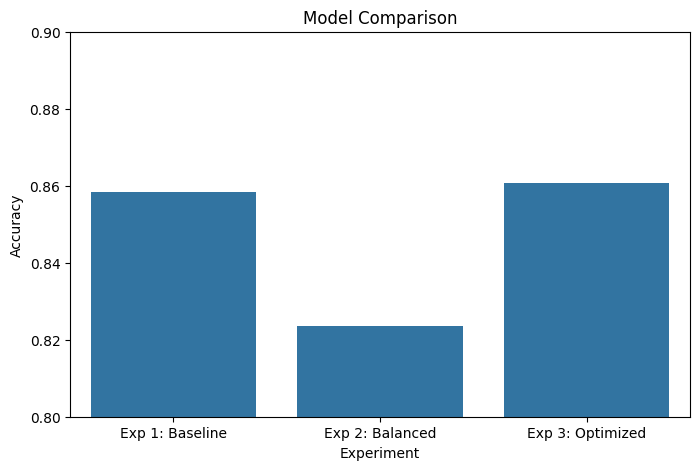

In [7]:
results_df = pd.DataFrame({
    'Experiment': ['Exp 1: Baseline', 'Exp 2: Balanced', 'Exp 3: Optimized'],
    'Accuracy': [acc1, acc2, acc3]
})

print(results_df)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='Experiment', y='Accuracy', data=results_df)
plt.ylim(0.8, 0.9)
plt.title('Model Comparison')
plt.show()


## Inference / Testing
Testing the best model on new, unseen text samples.

In [8]:
def predict_sentiment_inference(text, model):
    clean = clean_text(text)
    pred = model.predict([clean])
    label = le.inverse_transform(pred)[0]
    return label

# Example texts from inference.py
test_texts = [
    "Aplikasi ini sangat membantu, fitur lengkap!",
    "Sering crash saat dibuka, tolong diperbaiki.",
    "Biasa aja sih, standar aplikasi belanja.",
    "Barang sangat bagus, pengiriman cepat mantap!",
    "Kualitas produk hancur, saya sangat kecewa. Jangan beli disini.",
    "Lumayan lah untuk harga segitu, standar aja.",
    "Barang tidak sesuai pesanan, parah banget",
    "Suka banget sama produknya, bakal langganan"
]

print("--- Sentiment Analysis Inference ---")
model = pipeline3 # Use the optimized model from Exp 3

for text in test_texts:
    label = predict_sentiment_inference(text, model)
    print(f"Text: '{text}'\nSentiment: {label}\n")


--- Sentiment Analysis Inference ---
Text: 'Aplikasi ini sangat membantu, fitur lengkap!'
Sentiment: Positive

Text: 'Sering crash saat dibuka, tolong diperbaiki.'
Sentiment: Positive

Text: 'Biasa aja sih, standar aplikasi belanja.'
Sentiment: Positive

Text: 'Barang sangat bagus, pengiriman cepat mantap!'
Sentiment: Positive

Text: 'Kualitas produk hancur, saya sangat kecewa. Jangan beli disini.'
Sentiment: Negative

Text: 'Lumayan lah untuk harga segitu, standar aja.'
Sentiment: Positive

Text: 'Barang tidak sesuai pesanan, parah banget'
Sentiment: Negative

Text: 'Suka banget sama produknya, bakal langganan'
Sentiment: Positive

